## Clone Tensorflow Models Repository

In [1]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 66396, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 66396 (delta 50), reused 51 (delta 15), pack-reused 66306
Receiving objects: 100% (66396/66396), 575.86 MiB | 34.89 MiB/s, done.
Resolving deltas: 100% (46482/46482), done.


In [2]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

## Install the object detection API

In [3]:
!cd models/research && \
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

Processing /kaggle/working/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 352 kB 2.4 MB/s 
     |████████████████████████████████| 1.8 MB 31.1 MB/s 
     |████████████████████████████████| 61 kB 6.1 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 213 kB 54.5 MB/s 
     |████████████████████████████████| 99 kB 7.3 MB/s 
     |████████████████████████████████| 4.4 MB 36.5 MB/s 
     |████████████████████████████████| 90 kB 8.0 MB/s 
     |████████████████████████████████| 151 kB 51.5 MB/s 
     |████████████████████████████████| 21.8 MB 

## Import Libraries

In [4]:
import os
import pathlib
import tensorflow as tf

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2021-11-09 09:03:58.547183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 09:03:58.667170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 09:03:58.667973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Download Images

In [6]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

--2021-11-09 09:03:59--  https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195368 (191K) [image/jpeg]
Saving to: ‘walkingdog.jpeg’

walkingdog.jpeg     100%[===================>] 190.79K  1.12MB/s    in 0.2s    

2021-11-09 09:04:00 (1.12 MB/s) - ‘walkingdog.jpeg’ saved [195368/195368]

--2021-11-09 09:04:00--  https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160514 (157K) [image/jpeg]
Saving to: ‘traffic.jpeg’

traffic.jpeg        10

In [7]:
!ls

__notebook__.ipynb  jungle.jpeg  traffic.jpeg
intersection.jpeg   models	 walkingdog.jpeg


In [8]:
IMAGE_PATHS = [
  'intersection.jpeg', 'traffic.jpeg', 'jungle.jpeg', 'walkingdog.jpeg']

## Download and extract model files

Get URLs from the "Object Detection Zoo": https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [9]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'

PATH_TO_MODEL_DIR = tf.keras.utils.get_file(
    fname='ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
    origin=url,
    untar=True)

386539520/386527459 [==============================] - 3s 0us/step


In [10]:
PATH_TO_MODEL_DIR

'/root/.keras/datasets/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'

## Download Labels File

Label files can be found here: https://github.com/tensorflow/models/tree/master/research/object_detection/data

You probably won't need these since Object Detection Zoo contains only models trained on COCO.

In [11]:
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(
    fname='mscoco_label_map.pbtxt',
    origin=url,
    untar=False)

16384/5056 [=================================================================================================] - 0s 0us/step


In [12]:
PATH_TO_LABELS

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [13]:
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


## Load in the model

In [14]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...

2021-11-09 09:04:16.948788: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 09:04:16.950116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 09:04:16.950893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 09:04:16.951586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Done! Took 26.898087739944458 seconds


## Load in the labels

In [15]:
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS,
    use_display_name=True)

In [16]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Helper function

In [17]:
## Helper function

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

## Do some object detection

In [18]:
def detect_objects(image_path):
    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)

    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Do the detection
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # show classes
    # unique_classes = set(detections['detection_classes'])
    # print("Classes found:")
    # for c in unique_classes:
    #     print(category_index[c]['name'])

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure(figsize=(15, 10))
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

Running inference for intersection.jpeg... 

2021-11-09 09:04:45.416202: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-09 09:04:49.945304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Done


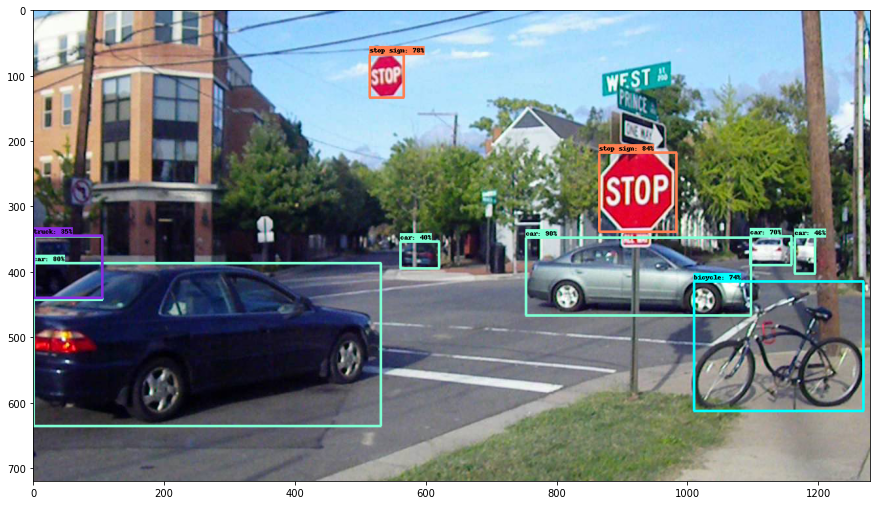

In [19]:
detect_objects(IMAGE_PATHS[0])

Running inference for traffic.jpeg... Done


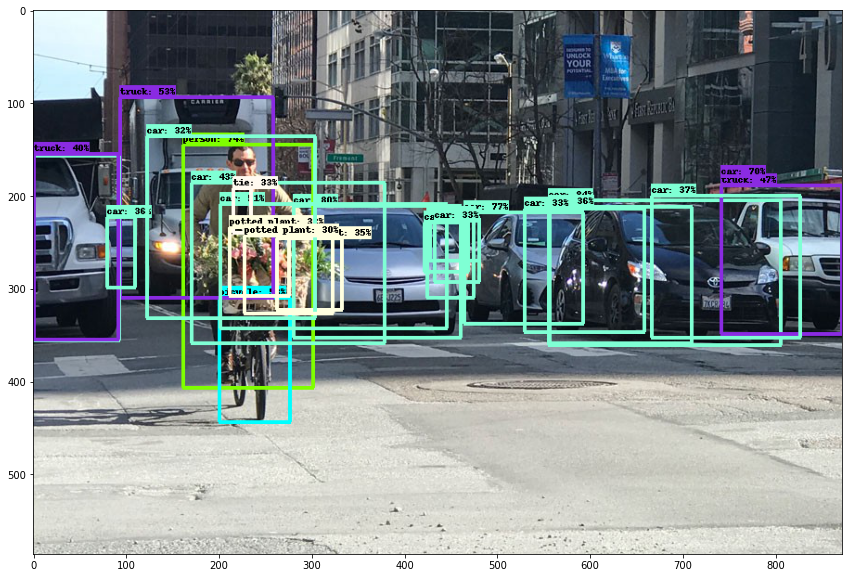

In [20]:
detect_objects(IMAGE_PATHS[1])

Running inference for jungle.jpeg... Done


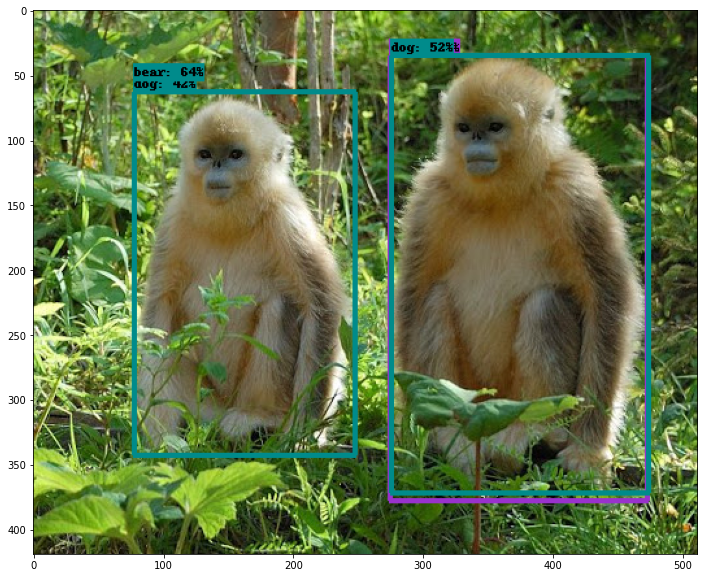

In [21]:
detect_objects(IMAGE_PATHS[2])

Running inference for walkingdog.jpeg... Done


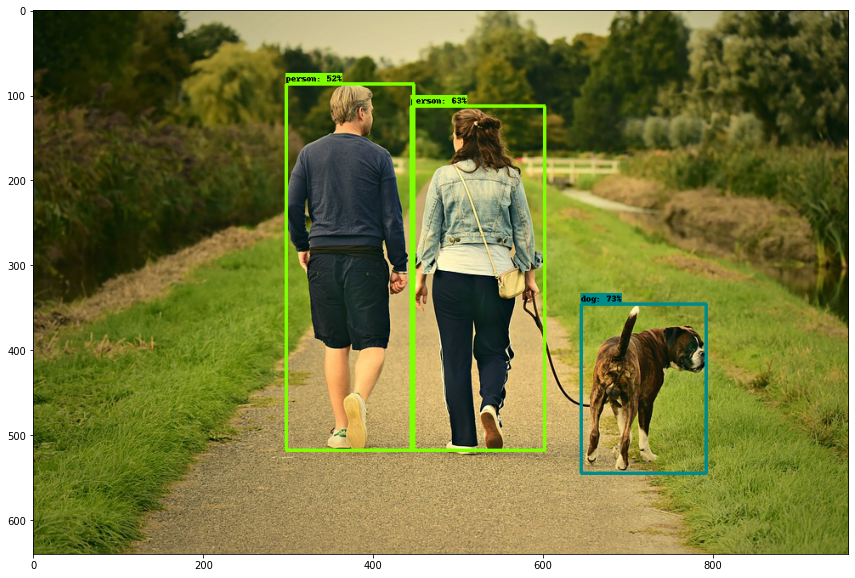

In [22]:
detect_objects(IMAGE_PATHS[3])